# TODO
- show pinyin on top of character

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
import time
import os
import pandas as pd
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings, delete_previous_attempt_files
    )
from utils_video import (
    combine_clips_with_audio_to_create_video, create_icon_from_slide,
    draw_word_index, draw_logo, draw_previous_word, draw_previous_sent,
    draw_vocab_based_on_format, generate_intro_slide,
    generate_word_list_slide, generate_outro_slide,
    overlay_one_image_on_another, create_icon_from_slide_general_path
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations,
    generate_nonvocab_audio_and_compute_durations, create_final_audio_from_each_word_and_nonvocab
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

In [3]:
# reload configs
from configs.v013_hsk5_v1 import (
    data_settings, output_path,
    video_configs, icon_configs,
    nonvocab_slides, subtitle_text_configs,
    DEFAULT_TEXT_PROPERTIES,
)
subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])

In [4]:
truly_load_data = False
to_delete = False

# 0. Create dataframe of settings

In [5]:
# Create settings df
data_settings = fill_default_settings(data_settings)

# Create folder for non-audio recordings for this project
project_artifacts_folder = f"{output_path}{data_settings['recording_name']}"

# Create folder if not exists, and delete previous files if desired
if not os.path.exists(project_artifacts_folder):
    os.mkdir(project_artifacts_folder)
if to_delete:
    delete_previous_attempt_files(project_artifacts_folder)


# Create folders for audio tts
tts_zh_path = f"output/tts/{data_settings['voice_name_zh']}"
tts_en_path = f"output/tts/{data_settings['voice_name_en']}"
if not os.path.exists(tts_zh_path):
    os.mkdir(tts_zh_path)
if not os.path.exists(tts_en_path):
    os.mkdir(tts_en_path)
data_settings

{'recording_id': 'ec_csent',
 'filename_suffix': 'hsk5_v1',
 'different_file_name': 'static/hsk/HSK5_sent_cat.csv',
 'custom_filters': [{'col_name': 'index', 'val': 0, 'operator_str': '>='},
  {'col_name': 'index', 'val': 9999, 'operator_str': '<='}],
 'sort_keys': ['category', 'index'],
 'sort_asc': [True, True],
 'voice_name_zh': 'zh-CN-XiaoyuMultilingualNeural',
 'voice_name_en': 'en-US-AvaMultilingualNeural',
 'pause_between_words_ms': 800,
 'min_priority': 1,
 'max_priority': 4,
 'min_known_english_prompt': 1,
 'max_known_english_prompt': 6,
 'min_known_pinyin_prompt': 1,
 'max_known_pinyin_prompt': 6,
 'types_allowed': ['combo',
  'no combo',
  'two word',
  'prefix',
  'single char',
  'suffix',
  'abbreviation',
  'phrase',
  'part sent',
  'phrase_save',
  'speak_phrase',
  'saying',
  'idiom',
  'slang',
  'signs',
  'signs_uncommon',
  'sentence',
  'proper noun',
  'idiom'],
 'min_combo_quality': 6,
 'categories_allowed': None,
 'categories2_allowed': None,
 'cat1_values_al

# 1. Load data

In [6]:
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('static/latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('static/latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
if len(df_dups) > 0:
    df_dups.head(20)
else:
    df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 2
(5480, 28)


# 2. Select data

In [7]:
df_vocab_lists = filter_df_to_vocab_of_interest(df_all_vocab, data_settings)
n_vocab = len(df_vocab_lists)
print(data_settings['recording_name'], n_vocab)
df_vocab_lists.head(3)

1003_ec_csent_hsk5_v1 1067


,index,chinese,trad,hsk3.0_pinyin,hsk3.0_def,video_notes,pinyin,english,sentence,sentence_pinyin,sentence_english,category
0,3,拔,拔,bá,"bare, tear, pluck, choose, take out, stand out...","HSK3.0 definition: bare, tear, pluck, choose, ...",bá,pull out,他用力把钉子拔出来了,tā yòng lì bǎ dīng zi bá chū lái le,He pulled the nail out with force,Actions & Verbs
1,4,按摩,按摩,ànmó,massage,HSK3.0 definition: massage,àn mó,massage,下班后我去按摩放松,xià bān hòu wǒ qù àn mó fàng sōng,After work I went for a massage to relax,Actions & Verbs
2,6,扮演,扮演,bànyǎn,"play part of, play part of","HSK3.0 definition: play part of, play part of",bàn yǎn,play a role,他在电影里扮演医生,tā zài diàn yǐng lǐ bàn yǎn yī shēng,He plays a doctor in the movie,Actions & Verbs


# 3. Create vocabulary audio recordings

In [8]:
if data_settings['recording_id'] == '005':
    df_vocab_lists = compute_pinyin_and_create_recordings(df_vocab_lists)

start_time = time.time()
for i_row, row in df_vocab_lists.iterrows():
    print(f"{(time.time()-start_time):.1f}s, row{i_row}")
    create_tts_files_for_one_vocab_word(row, data_settings)

0.0s, row0
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 拔
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, pull out
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 他用力把钉子拔出来了
0.0s, row1
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 按摩
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, massage
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 下班后我去按摩放松
0.0s, row2
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 扮演
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, play a role
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 他在电影里扮演医生
0.0s, row3
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 拜访
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, visit
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 我打算明天拜访老师
0.0s, row4
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 包围
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, surround
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 小镇被大雪包围了
0.0s, row5
0

## 3b. Compute durations of combined audios for each vocab word

In [9]:
audio_duration_file_name = f"{project_artifacts_folder}/audio_durations_vocab_only.csv"
if os.path.exists(audio_duration_file_name):
    df_vocab_audio_durations = pd.read_csv(audio_duration_file_name)
    print(f"Loaded existing audio durations for {data_settings['recording_name']}, shape {df_vocab_audio_durations.shape}")
else:
    df_vocab_audio_durations = combine_audio_files_and_compute_durations(df_vocab_lists, data_settings)
    df_vocab_audio_durations.to_csv(audio_duration_file_name, index=False)

df_vocab_audio_durations['nonvocab_file_path'] = None
df_vocab_audio_durations['nonvocab_pause_ms'] = None
df_vocab_audio_durations['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations['combined'].sum()}s")
df_vocab_audio_durations.head(3)

Loaded existing audio durations for 1003_ec_csent_hsk5_v1, shape (1067, 15)
Total duration: 6785.068333333333s


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,拔,bá,pull out,他用力把钉子拔出来了,tā yòng lì bǎ dīng zi bá chū lái le,He pulled the nail out with force,1.056,0.888,2.592,0,1.556,2.944,6.336,6.335667,"HSK3.0 definition: bare, tear, pluck, choose, ...",None,None,None
1,按摩,àn mó,massage,下班后我去按摩放松,xià bān hòu wǒ qù àn mó fàng sōng,After work I went for a massage to relax,1.176,1.008,2.664,0,1.676,3.184,6.648,6.647667,HSK3.0 definition: massage,None,None,None
2,扮演,bàn yǎn,play a role,他在电影里扮演医生,tā zài diàn yǐng lǐ bàn yǎn yī shēng,He plays a doctor in the movie,1.224,1.104,2.208,0,1.724,3.328,6.336,6.335667,"HSK3.0 definition: play part of, play part of",None,None,None


# 4. Create non-vocab audio recordings

In [10]:
df_vocab_audio_durations, audio_filler_variables, nonvocab_slides = generate_nonvocab_audio_and_compute_durations(
    data_settings, df_vocab_audio_durations, nonvocab_slides, project_artifacts_folder)
df_vocab_audio_durations.head()

intro audio already generated: 欢迎观看我的普通话数据库视频 13: HSK5级音频卡片
word_list audio already generated: 这些是将在接下来的113分钟内复习的1067个单词
outro audio already generated: 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 13: HSK5级音频卡片,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.910000,NaN,output/videos/1003_ec_csent_hsk5_v1/欢迎观看我的普通话数...,500,intro,6.910000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的113分钟内复习的1067个单词,Zhèxiē shì jiàng zài jiē xiàlái de 113 fēnzhōn...,These are the 1067 words that will be reviewed...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.150000,NaN,output/videos/1003_ec_csent_hsk5_v1/这些是将在接下来的1...,500,word_list,14.060000,6.910000,NaN,NaN,NaN
2,拔,bá,pull out,他用力把钉子拔出来了,tā yòng lì bǎ dīng zi bá chū lái le,He pulled the nail out with force,1.056,0.888,2.592,0.0,1.556,2.944,6.336,6.335667,"HSK3.0 definition: bare, tear, pluck, choose, ...",None,None,None,20.395667,14.060000,14.060000,15.616000,17.004000
3,按摩,àn mó,massage,下班后我去按摩放松,xià bān hòu wǒ qù àn mó fàng sōng,After work I went for a massage to relax,1.176,1.008,2.664,0.0,1.676,3.184,6.648,6.647667,HSK3.0 definition: massage,None,None,None,27.043333,20.395667,20.395667,22.071667,23.579667
4,扮演,bàn yǎn,play a role,他在电影里扮演医生,tā zài diàn yǐng lǐ bàn yǎn yī shēng,He plays a doctor in the movie,1.224,1.104,2.208,0.0,1.724,3.328,6.336,6.335667,"HSK3.0 definition: play part of, play part of",None,None,None,33.379000,27.043333,27.043333,28.767333,30.371333


# 5. Combine individual vocab into final audio recording

In [11]:
create_final_audio_from_each_word_and_nonvocab(df_vocab_audio_durations, project_artifacts_folder, data_settings)

123.58s, output/videos/1003_ec_csent_hsk5_v1/audio.mp3


# 6. Create images for video

In [12]:
# If don't want to rerun the above cells, then just run this cell to load the audio durations
audio_generation_previous_run = True
if audio_generation_previous_run:
    try:
        df_vocab_audio_durations = pd.read_csv(f"{project_artifacts_folder}/audio_durations_all.csv")
        print(f"{data_settings['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {data_settings['recording_name']}, please run the cell above to generate audio durations.")
df_vocab_audio_durations.head()

1003_ec_csent_hsk5_v1 loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 13: HSK5级音频卡片,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.910000,NaN,output/videos/1003_ec_csent_hsk5_v1/欢迎观看我的普通话数...,500.0,intro,6.910000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的113分钟内复习的1067个单词,Zhèxiē shì jiàng zài jiē xiàlái de 113 fēnzhōn...,These are the 1067 words that will be reviewed...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.150000,NaN,output/videos/1003_ec_csent_hsk5_v1/这些是将在接下来的1...,500.0,word_list,14.060000,6.910000,NaN,NaN,NaN
2,拔,bá,pull out,他用力把钉子拔出来了,tā yòng lì bǎ dīng zi bá chū lái le,He pulled the nail out with force,1.056,0.888,2.592,0.0,1.556,2.944,6.336,6.335667,"HSK3.0 definition: bare, tear, pluck, choose, ...",NaN,NaN,NaN,20.395667,14.060000,14.060000,15.616000,17.004000
3,按摩,àn mó,massage,下班后我去按摩放松,xià bān hòu wǒ qù àn mó fàng sōng,After work I went for a massage to relax,1.176,1.008,2.664,0.0,1.676,3.184,6.648,6.647667,HSK3.0 definition: massage,NaN,NaN,NaN,27.043333,20.395667,20.395667,22.071667,23.579667
4,扮演,bàn yǎn,play a role,他在电影里扮演医生,tā zài diàn yǐng lǐ bàn yǎn yī shēng,He plays a doctor in the movie,1.224,1.104,2.208,0.0,1.724,3.328,6.336,6.335667,"HSK3.0 definition: play part of, play part of",NaN,NaN,NaN,33.379000,27.043333,27.043333,28.767333,30.371333


## 6a. Vocab words

Drawing 0: 拔
Drawing 1: 按摩
Drawing 2: 扮演
Drawing 3: 拜访
Drawing 4: 包围
Drawing 5: 保卫
Drawing 6: 报答
Drawing 7: 报警
Drawing 8: 保养
Drawing 9: 变动
Drawing 10: 补偿
Drawing 11: 猜测
Drawing 12: 采购
Drawing 13: 猜
Drawing 14: 查询
Drawing 15: 插
Drawing 16: 拆除
Drawing 17: 拆
Drawing 18: 尝
Drawing 19: 尝试
Drawing 20: 超越
Drawing 21: 倡导
Drawing 22: 称
Drawing 23: 成交
Drawing 24: 承办
Drawing 25: 乘
Drawing 26: 乘车
Drawing 27: 乘坐
Drawing 28: 冲突
Drawing 29: 出差
Drawing 30: 出版
Drawing 31: 出汗
Drawing 32: 传达
Drawing 33: 传递
Drawing 34: 传真
Drawing 35: 闯
Drawing 36: 创立
Drawing 37: 辞职
Drawing 38: 达成
Drawing 39: 答复
Drawing 40: 答
Drawing 41: 打
Drawing 42: 打扮
Drawing 43: 打击
Drawing 44: 打包
Drawing 45: 打扰
Drawing 46: 打架
Drawing 47: 待
Drawing 48: 带有
Drawing 49: 当选
Drawing 50: 挡
Drawing 51: 到来
Drawing 52: 等候
Drawing 53: 递
Drawing 54: 递给
Drawing 55: 点燃
Drawing 56: 丢
Drawing 57: 调动
Drawing 58: 动手
Drawing 59: 动员
Drawing 60: 对应
Drawing 61: 躲
Drawing 62: 发觉
Drawing 63: 发射
Drawing 64: 发行
Drawing 65: 发布
Drawing 66: 返回
Drawing 67: 放大
Drawi


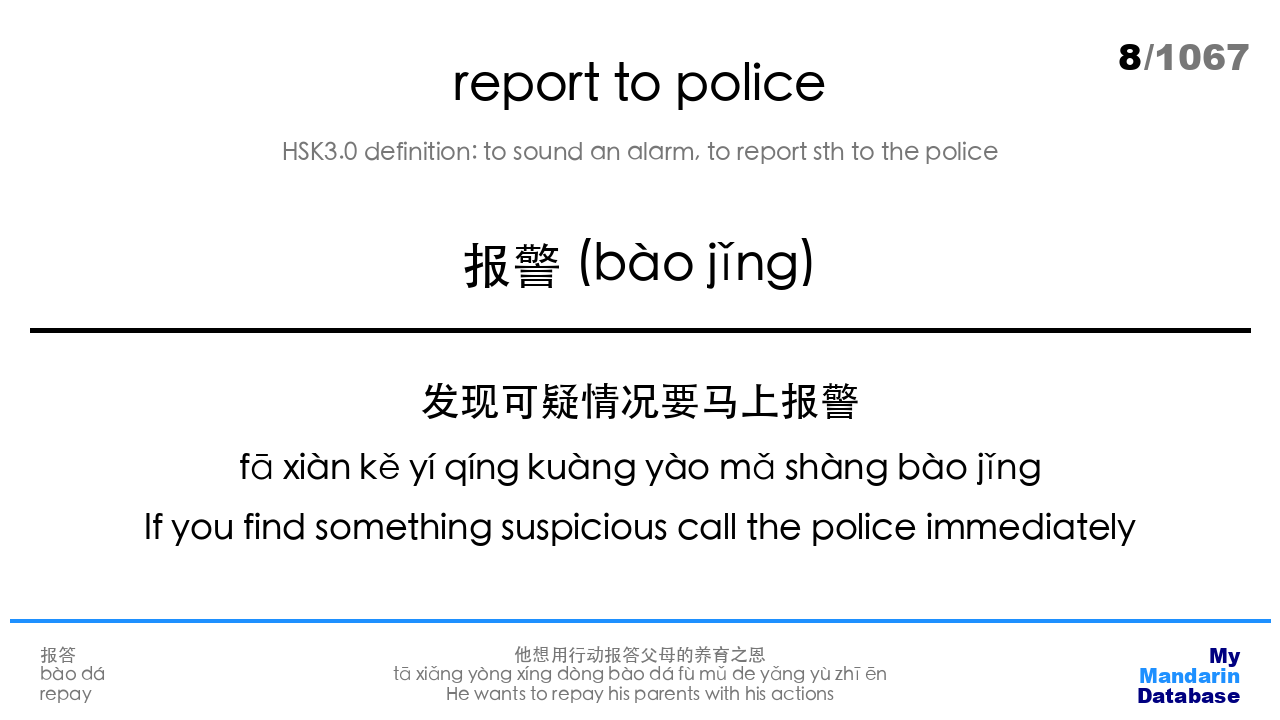

In [13]:
# Overall initializations
clips = []
previous_word = ''
previous_sent = ''

# Create folder to hold slide images
slides_path = f"{project_artifacts_folder}/slides"
if not os.path.exists(slides_path):
    os.mkdir(slides_path)

# Fill in defaults for any missing properties
for config_key, default_config_value in DEFAULT_TEXT_PROPERTIES.items():
    for vocab_slide_id, vocab_slide_settings in video_configs['vocab_slide'].items():
        if config_key not in vocab_slide_settings.keys():
            video_configs['vocab_slide'][vocab_slide_id][config_key] = default_config_value

# Iterate through each word
df_audio_durations_words_only = df_vocab_audio_durations.dropna(subset='sum_theory').reset_index(drop=True)
for word_idx, row in df_audio_durations_words_only.iterrows():
    # Initialize image
    print(f'Drawing {word_idx}: {row["chinese"]}')
    current_image_file_path = f"{slides_path}/{row['chinese']}"
    img = Image.new("RGB", video_configs['bg_size'], color=video_configs['bg_color'])
    draw = ImageDraw.Draw(img)
    
    # Header/Footer texts
    draw_word_index(draw, video_configs, n_vocab, word_idx)
    draw_logo(draw, video_configs)
    draw_previous_word(draw, video_configs, previous_word)
    draw_previous_sent(draw, video_configs, previous_sent)
    draw.line([
        (video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y']),
        (video_configs['bg_size'][0] - video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y'])],
        fill=video_configs['footer_line']['color'],
        width=video_configs['footer_line']['width'],
        joint=None)
    
    # Update previous
    previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
    if data_settings['recording_id'] in ['013', 'ceword_csent', 'ceword_components_cesent', 'ceword_components_csent', 'ec_csent']:
        previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

    # Draw vocab depending on recording ID
    draw_vocab_based_on_format(data_settings['recording_id'], row, video_configs, current_image_file_path, img, draw, clips)

clips[23].display_in_notebook()

# 7. Create non-vocab slides


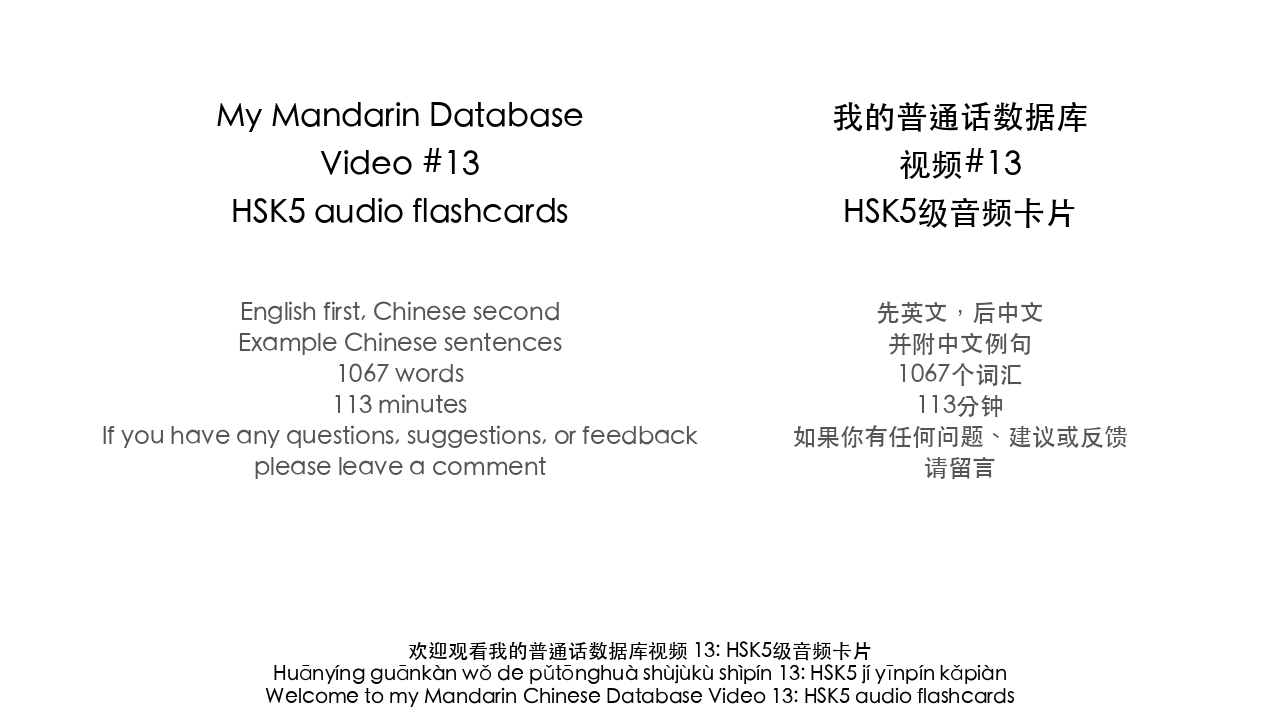

In [14]:
if 'intro' in nonvocab_slides.keys():
    img = generate_intro_slide(video_configs, nonvocab_slides['intro'], subtitle_text_configs, audio_filler_variables)
    img.save(f"{project_artifacts_folder}/intro.png")
my_img = ImageClip(f"{project_artifacts_folder}/intro.png", duration=1).with_start(0)
my_img.display_in_notebook()

reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced text to report to polic
reduced text to report to poli
reduced text to report to pol
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced fo


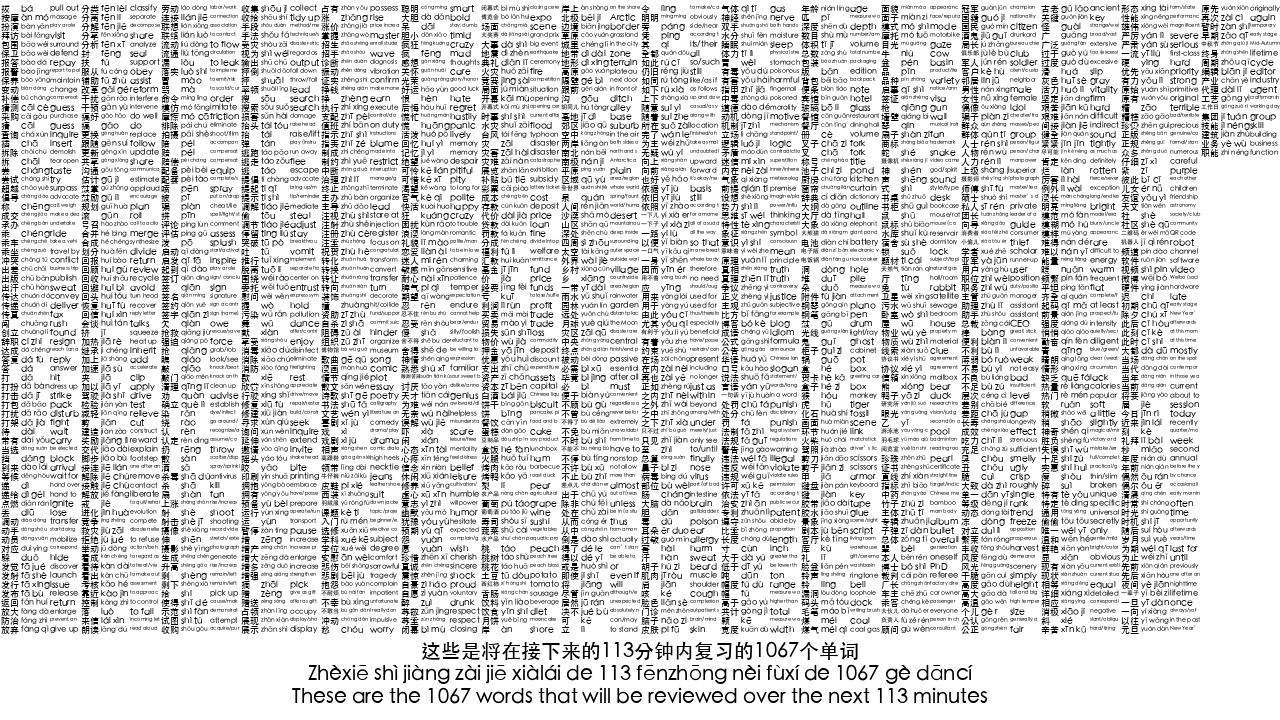

In [15]:
if 'word_list' in nonvocab_slides.keys():
    img = generate_word_list_slide(video_configs, nonvocab_slides['word_list'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/word_list.png")
my_img = ImageClip(f"{project_artifacts_folder}/word_list.png", duration=1).with_start(0)
my_img.display_in_notebook()

reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced text to report to polic
reduced text to report to poli
reduced text to report to pol
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced fo


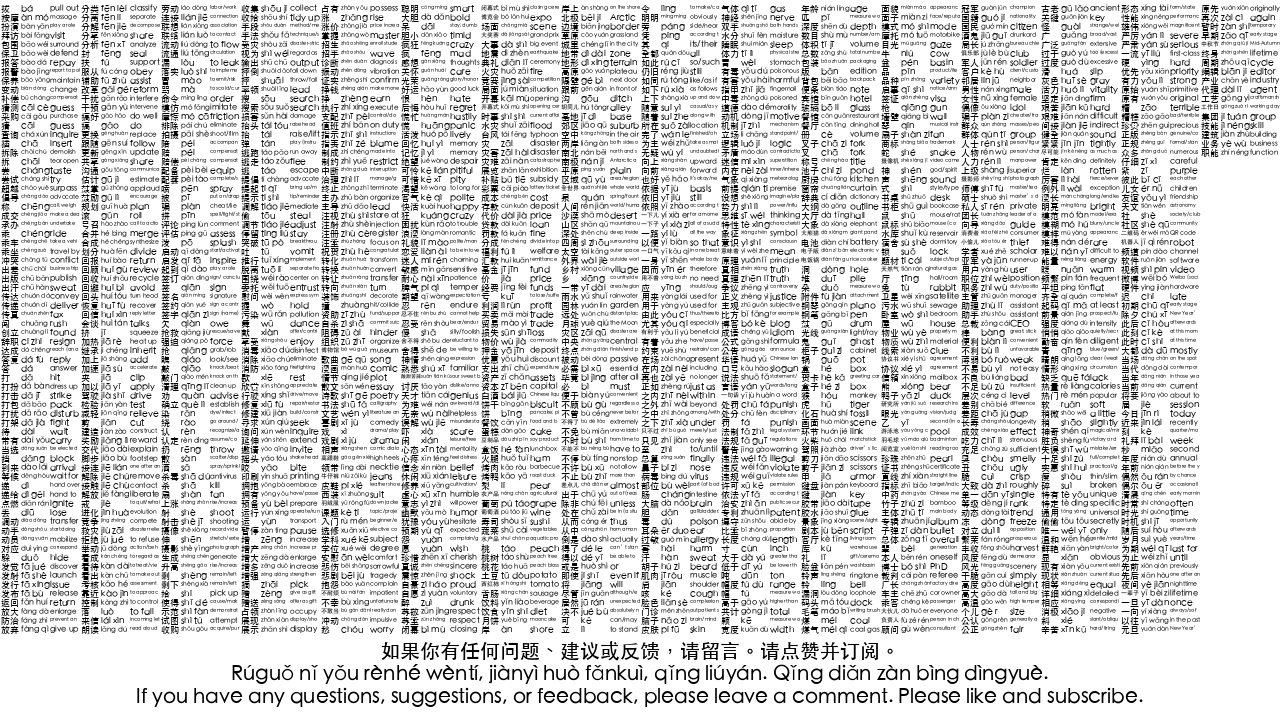

In [16]:
if 'outro' in nonvocab_slides.keys():
    img = generate_outro_slide(video_configs, nonvocab_slides['outro'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/outro.png")
my_img = ImageClip(f"{project_artifacts_folder}/outro.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 8. Create video icon


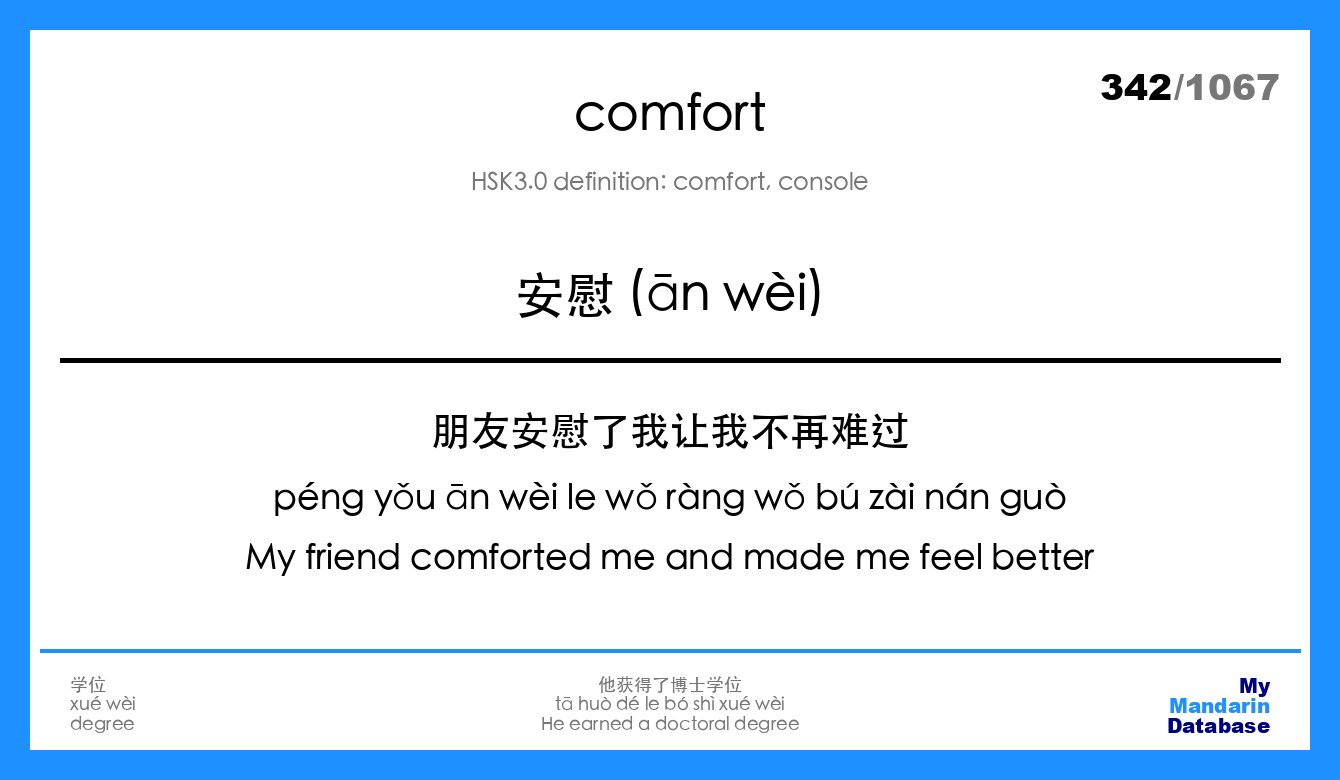

In [17]:
img = create_icon_from_slide(icon_configs, video_configs, project_artifacts_folder)
img.save(f'{project_artifacts_folder}/icon.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon.png", duration=1).with_start(0)
my_img.display_in_notebook()


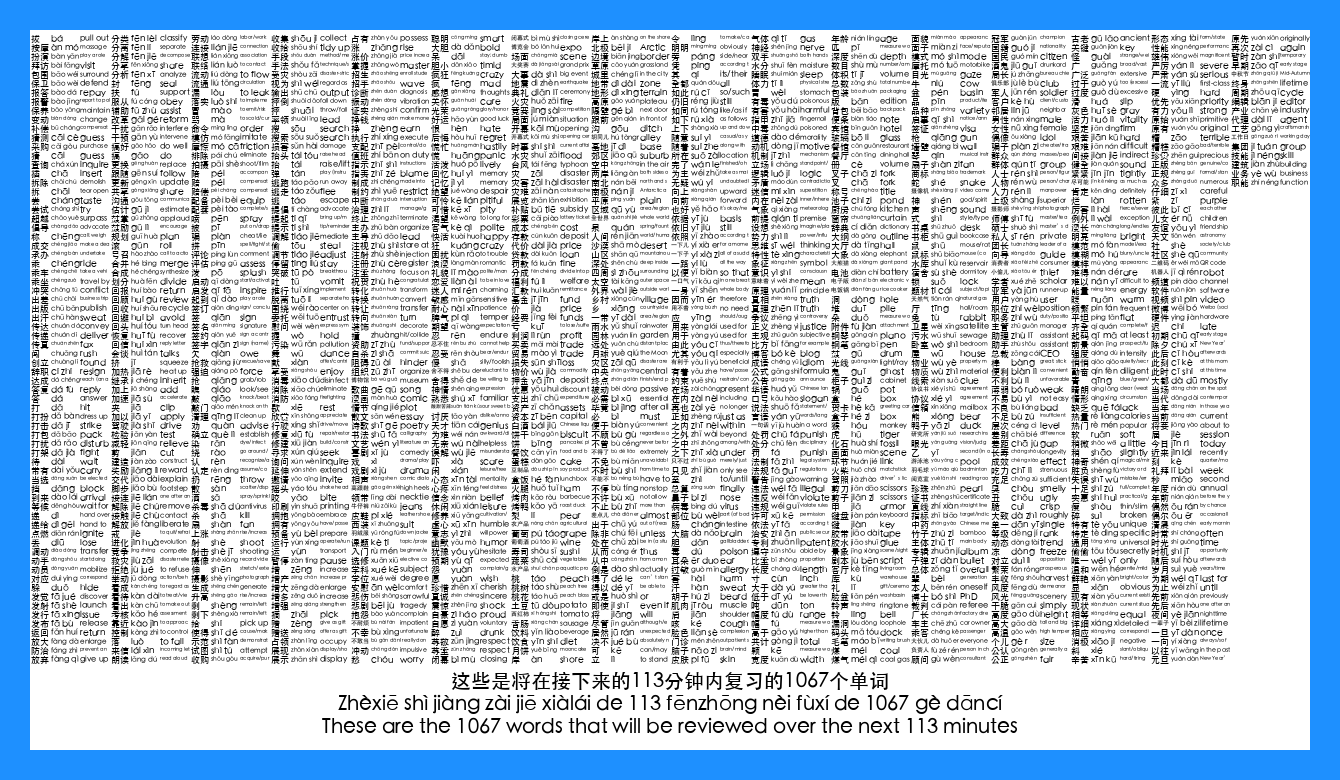

In [18]:
path_to_bottom_image = f"{project_artifacts_folder}/word_list.png"
img = create_icon_from_slide_general_path(icon_configs, video_configs, path_to_bottom_image)
img.save(f'{project_artifacts_folder}/icon2.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon2.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 9. Create video

In [ ]:
combine_clips_with_audio_to_create_video(clips, nonvocab_slides, project_artifacts_folder)

Number of clips: 3204
audio: 6805.700s, video: 6805.648s; difference: 0.052s
MoviePy - Building video output/videos/1003_ec_csent_hsk5_v1/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/videos/1003_ec_csent_hsk5_v1/video.mp4



frame_index:  30%|██▉       | 48734/163336 [27:29<1:32:42, 20.60it/s, now=None]